In [7]:
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import stanza

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import brown
from nltk import wordpunct_tokenize # tokenize for non-English languages

nltk.download('brown')
fd = nltk.FreqDist(brown.words())

[nltk_data] Downloading package brown to
[nltk_data]     /Users/michaelhuang/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [8]:
def fetch_text(dataset):
    human_text = dataset['text'][dataset.label == 0].tolist()
    machine_text = dataset['text'][dataset.label == 1].tolist()
    return human_text, machine_text

In [23]:
df_raw = pd.read_csv('GPT-wiki-intro.csv')

human_text = df_raw['wiki_intro'].to_list()
machine_text = df_raw['generated_intro'].to_list()

df_wiki = pd.DataFrame({
    'text': human_text + machine_text,
    'label': len(human_text) * [0] + len(machine_text) * [1]
})

df_wiki.sample(5)

,text,label
276888,The streak (Chesias legatella) is a moth of th...,1
50440,Roger Orton (c. 1799 – 1851) was an early Morm...,0
112072,"The ""Bosom Friends"" affair was an academic and...",0
116404,Indu Sarkar is a 2017 Indian period political ...,0
25970,Blanchard Springs Caverns is a cave system loc...,0


In [12]:
train_df, test_df = train_test_split(df_wiki, test_size=0.2)
train_df.to_csv(f'train_wiki.csv', index=False)
test_df.to_csv(f'test_wiki.csv', index=False)

In [13]:
train_df = pd.read_csv('train_wiki.csv')
test_df = pd.read_csv('test_wiki.csv')
dataset_name = 'GPT-wiki'

### Answer Length

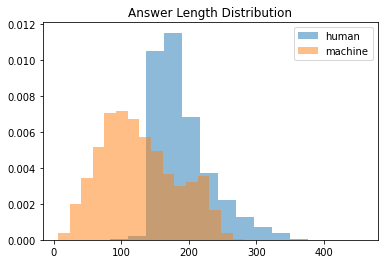

In [14]:
def text_length(all_text):
    list_of_words = [[word for word in wordpunct_tokenize(text) if word.isalpha()] for text in all_text]
    list_of_len = [len(words) for words in list_of_words]
    return list_of_len

human_text, machine_text = fetch_text(train_df)

human_len = text_length(human_text)
machine_len = text_length(machine_text)

plt.hist(human_len, bins=16, alpha=0.5, label='human', density=True)
plt.hist(machine_len, bins=16, alpha=0.5, label='machine', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Answer Length Distribution")
plt.savefig(f'img/{dataset_name}_length.png')

### Sentence Length

In [18]:
def sentence_length(all_text):
    list_of_sentences = [nltk.sent_tokenize(text) for text in all_text]
    list_of_len = [len(sentences) for sentences in list_of_sentences]
    return list_of_len

In [19]:
human_text, machine_text = fetch_text(train_df)

human_sents = [sent_tokenize(p) for p in tqdm(human_text)]
machine_sents = [sent_tokenize(p) for p in tqdm(machine_text)]

avg_word_in_sent_human, avg_word_in_sent_machine = [], []
for sents in tqdm(human_sents):
    avg_word_in_sent_human.append(np.mean([len(word_tokenize(s)) for s in sents]))
for sents in tqdm(machine_sents):
    avg_word_in_sent_machine.append(np.mean([len(word_tokenize(s)) for s in sents]))

100%|██████████| 120249/120249 [02:19<00:00, 861.30it/s]


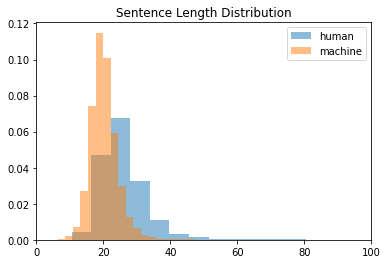

In [20]:
plt.hist(avg_word_in_sent_human, bins=100, alpha=0.5, label='human', density=True)
plt.hist(avg_word_in_sent_machine, bins=100, alpha=0.5, label='machine', density=True)
plt.xlim(xmin=0, xmax=100)
plt.legend(loc='upper right')
plt.title("Sentence Length Distribution")
plt.savefig(f'img/{dataset_name}_sentence.png')

### Frequent Words

In [21]:
def freq_func(text, fd):
    all_text = ' '.join(text)
    words = wordpunct_tokenize(all_text)
    words = [word.lower() for word in words if word.isalpha()]
    freq = [fd[word] for word in words]
    words_len = np.mean([len(word) for word in words])
    rare_words = [word for word in words if fd[word] < 100]
    print(len(rare_words), rare_words[0:10]) # avoid printing too much rare words
    norm_freq = np.array(freq)
    return norm_freq, words_len


In [22]:
human_text, machine_text = fetch_text(train_df)

human_freq, human_words_len = freq_func(human_text, fd)
machine_freq, machine_words_len = freq_func(machine_text, fd)

9986451 ['guitar', 'chord', 'notes', 'guitar', 'chord', 's', 'notes', 'simultaneously', 'sequentially', 'arpeggio']
6254862 ['eliduc', 'breton', 'lai', 'poet', 'marie', 'de', 'france', 'tells', 'eliduc', 'spite']


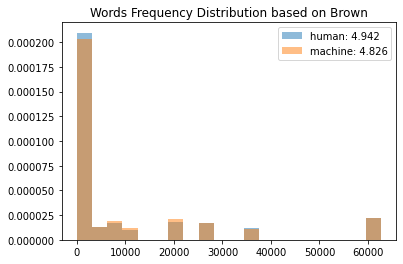

In [17]:
plt.hist(human_freq, bins=20, alpha=0.5, label=f'human: {human_words_len:.3f}', density=True)
plt.hist(machine_freq, bins=20, alpha=0.5, label=f'machine: {machine_words_len:.3f}', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Words Frequency Distribution based on Brown")
plt.savefig(f'img/{dataset_name}_freq.png')

### POS tagging

In [24]:
def dict_add(list_of_dicts):
    items = set().union(*list_of_dicts)
    res = {}
    for item in items:
        res[item] = sum(d.get(item, 0) for d in list_of_dicts) / len(list_of_dicts)
    return res

In [31]:
def pos_func(text, nlp):
    pos_dict = defaultdict(int)
    for sent in text:
        doc = nlp(sent)
        for sent in doc.sentences:
            for word in sent.words:
                pos_dict[word.xpos] += 1
    return pos_dict

def norm_func(human_dist, machine_dist):
    all_keys = sorted(set().union(human_dist.keys(), machine_dist.keys()))
    human_dist_norm = {k: human_dist.get(k, 0)  / sum(human_dist.values()) for k in all_keys}
    machine_dist_norm = {k: machine_dist.get(k, 0) / sum(machine_dist.values()) for k in all_keys}
    return human_dist_norm, machine_dist_norm

def pipe_add(func, all_text, nlp):
    dict_func =  [func(text, nlp) for text in tqdm(all_text)]
    dict_all = dict_add(dict_func)
    return dict_all

def draw_func(human_dist_norm, machine_dist_norm, dataset_name, func_name):
    plt.style.use('default')
    plt.bar(x=list(human_dist_norm.keys()), height=list(human_dist_norm.values()), alpha=0.5, label='human')
    plt.bar(x=list(machine_dist_norm.keys()), height=list(machine_dist_norm.values()), alpha=0.5, label='machine')

    # rotate the x-axis labels
    plt.xticks(rotation=90)
    plt.legend()
    if func_name == "deprel":
        plt.title(f'Dependency Relation Distribution on {dataset_name}')
    elif func_name == "xpos":
        plt.title(f'POS Tagging Distribution on {dataset_name}')
    plt.savefig(f'img/{dataset_name}_{func_name}.png', dpi=300)
    plt.show()

2023-04-18 19:53:33 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-18 19:53:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-04-18 19:53:33 INFO: Using device: cpu
2023-04-18 19:53:33 INFO: Loading: tokenize
2023-04-18 19:53:33 INFO: Loading: pos
2023-04-18 19:53:33 INFO: Done loading processors!
100%|██████████| 140/140 [31:14<00:00, 13.39s/it]

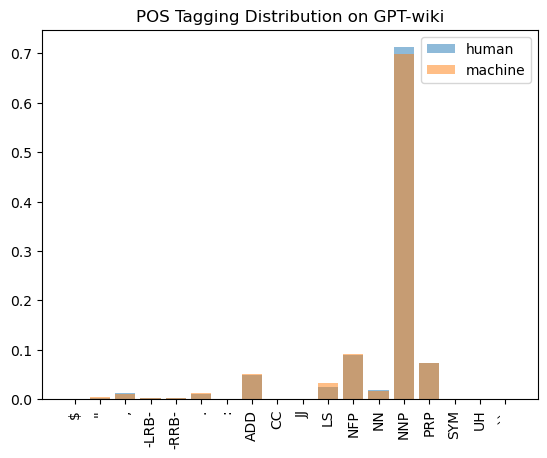

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')
human_text, machine_text = fetch_text(train_df.sample(300))

human_dict = pipe_add(pos_func, human_text, nlp)
machine_dict = pipe_add(pos_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "xpos")

### Dependency Parsing

In [25]:
def deprel_func(sentences, nlp):
    doc = nlp(sentences)
    deprel_dist = defaultdict(int)
    for sent in doc.sentences:
        for word in sent.words:
            deprel_dist[word.deprel] += 1
    return deprel_dist

2023-04-18 19:26:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-18 19:26:10 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-18 19:26:10 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-04-18 19:26:10 INFO: Using device: cuda
2023-04-18 19:26:10 INFO: Loading: tokenize
2023-04-18 19:26:10 INFO: Loading: pos
2023-04-18 19:26:11 INFO: Loading: lemma
2023-04-18 19:26:11 INFO: Loading: depparse
2023-04-18 19:26:11 INFO: Done loading processors!
100%|██████████| 4976/4976 [09:05<00:00,  9.12it/s]


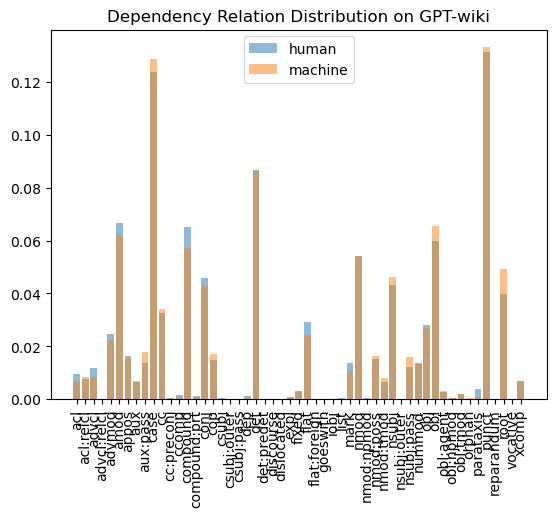

In [29]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
human_text, machine_text = fetch_text(train_df.sample(10000))

human_dict = pipe_add(deprel_func, human_text, nlp)
machine_dict = pipe_add(deprel_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "deprel")